In [67]:
import qiskit
import qiskit_algorithms
import qiskit_optimization

from qiskit_aer import AerSimulator

from qiskit.primitives import Sampler
# from qiskit.primitives import BackendSamplerV2 
# from qiskit.primitives import StatevectorSampler #takes 2 args but 3 are passed assuming Sampler :(
# from qiskit_ibm_runtime import SamplerV2 #needs backend

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit.library import RYGate, XGate, CXGate
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

from qiskit_algorithms import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA

from qiskit_optimization.algorithms import MinimumEigenOptimizer, SolutionSample, OptimizationResultStatus
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty, LinearInequalityToPenalty, QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp # creates QuadraticProgram from docplex model

from qiskit.visualization import plot_histogram, plot_state_city, plot_state_qsphere, plot_bloch_multivector, plot_distribution

import networkx as nx
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import math
import time
import contextlib
import io
from IPython.display import display, Math

# from qiskit_algorithms.utils import algorithm_globals
# algorithm_globals.random_seed = 123

import warnings
# Suppress specific DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)


print("qiskit version:",qiskit.__version__)
print("qiskit algorithms version:",qiskit_algorithms.__version__)
print("qiskit optimization version:",qiskit_optimization.__version__)

qiskit version: 1.3.2
qiskit algorithms version: 0.3.1
qiskit optimization version: 0.6.1


In [68]:
# Load MATLAB file
data = scipy.io.loadmat('ifiss3.6/QUBO_4.mat') #16 vars for prob 3, 12 for 4 

# Extract matrices as NumPy arrays
Phi = np.array(data['Phi'])
M = np.array(data['M'].toarray())
Kinv = np.array(data['Kinv'])
yhat_vec = np.array(data['yhat_vec']).squeeze()  # for 1D array

# Hamming weight upper bound
s=3

print('Phi shape:', Phi.shape)
print('M shape:', M.shape)
print('Kinv shape:', Kinv.shape)
print('yhat_vec shape:', yhat_vec.shape)

Phi shape: (289, 12)
M shape: (289, 289)
Kinv shape: (289, 289)
yhat_vec shape: (289,)


In [69]:
def generate_pde_qubo(M, Kinv, Phi, yd):
    
    Q = np.array((1/2) * Phi.T @ M @ Kinv @ M @ Kinv @ M @ Phi)

    q = np.array((1/2) * (yd.T @ M @ Kinv @ M @ Phi).T - (Phi.T @ M @ Kinv.T @ M @ yd))

    c = np.array((1/2) * yd.T @ M @ yd)

    return Q, q, c

def pad_zeros(Q, q, s):
    # Pad Q and q with zeros to match the shape of the QUBO matrix
    n = Q.shape[0]
    padded_Q = np.zeros((n + s, n + s))
    padded_Q[:n, :n] = Q

    padded_q = np.zeros(n + s)
    padded_q[:n] = q

    return padded_Q, padded_q

Q, q, c = generate_pde_qubo(M, Kinv, Phi, yhat_vec)

print('Q shape: ', Q.shape)
print('q shape: ', q.shape)
print('c shape: ', c.shape)

Q shape:  (12, 12)
q shape:  (12,)
c shape:  ()


In [70]:
padded_Q, padded_q = pad_zeros(Q, q, s)
print('padded Q shape: ', padded_Q.shape)
print('padded q shape: ', padded_q.shape)

padded Q shape:  (15, 15)
padded q shape:  (15,)


In [71]:
#set random seed
#np.random.seed(1234)

display(Math(r"\min_{x\in\{0,1\}^n} x^T Q x + q^T x + c \quad \text{s.t.} \quad x^T x = s"))

# make an empty problem
prob_size = q.size + s


bqo = QuadraticProgram("PDE constrained BQO")
binary_vars = [bqo.binary_var(name=f"x{i}") for i in range(prob_size)]

# Add the Hamming weight constraint: sum(x[i]) == s
bqo.linear_constraint(
    linear={f"x{i}": 1 for i in range(prob_size)},
    sense="==",
    rhs=s,
    name="hamming_weight"
)

# Add objective function using lists/arrays
bqo.minimize(
    constant=c,
    linear=padded_q,
    quadratic=padded_Q
    )

print(bqo.prettyprint())

<IPython.core.display.Math object>

Problem name: PDE constrained BQO

Minimize
  5.207619646581198*x0^2 + 10.415239293162395*x0*x1 + 10.415239293162395*x0*x10
  + 10.415239293162395*x0*x11 + 10.415239293162395*x0*x2
  + 10.415239293162395*x0*x3 + 10.415239293162395*x0*x4
  + 10.415239293162395*x0*x5 + 10.415239293162395*x0*x6
  + 10.415239293162395*x0*x7 + 10.415239293162395*x0*x8
  + 10.415239293162395*x0*x9 + 5.207619646581198*x1^2
  + 10.415239293162395*x1*x10 + 10.415239293162395*x1*x11
  + 10.415239293162395*x1*x2 + 10.415239293162395*x1*x3
  + 10.415239293162395*x1*x4 + 10.415239293162395*x1*x5
  + 10.415239293162395*x1*x6 + 10.415239293162395*x1*x7
  + 10.415239293162395*x1*x8 + 10.415239293162395*x1*x9
  + 5.207619646581198*x10^2 + 10.415239293162395*x10*x11
  + 5.207619646581198*x11^2 + 10.415239293162395*x2*x10
  + 10.415239293162395*x2*x11 + 5.207619646581198*x2^2
  + 10.415239293162395*x2*x3 + 10.415239293162395*x2*x4
  + 10.415239293162395*x2*x5 + 10.415239293162395*x2*x6
  + 10.415239293162395*x2*x7 + 10.4

In [72]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

# Assuming bqo is an instance of QuadraticProgram
# Create a classical solver
eigen_solver = NumPyMinimumEigensolver()

# Create the optimizer
optimizer = MinimumEigenOptimizer(eigen_solver)

# Solve the problem
result = optimizer.solve(bqo)
optimal_value = result.fval

# Print the solution
print("solution:", result.prettyprint())
print("Hamming weight:", sum(result.x))

solution: objective function value: 5.626523996144061
variable values: x0=0.0, x1=0.0, x2=0.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=0.0, x8=0.0, x9=0.0, x10=0.0, x11=0.0, x12=0.0, x13=1.0, x14=1.0
status: SUCCESS
Hamming weight: 3.0


In [73]:
bqo.remove_linear_constraint("hamming_weight") # to enforce with mixer instead of penalty

# Initial State Preparation Circuits:

In [74]:
# make initial state
from qiskit import QuantumCircuit

init_qc = QuantumCircuit(prob_size)
for idx in range(s):
    init_qc.x(idx)

#init_qc.draw(output="mpl")

In [75]:
# A better option: Dicke States
from itertools import combinations
from qiskit.circuit.library import Initialize

def prepare_dicke_state_qiskit(n, s):
    qc = QuantumCircuit(n)

    dicke_basis = list(combinations(range(n), s))
    norm = 1 / math.sqrt(len(dicke_basis))

    state = [0] * (2**n)
    for basis in dicke_basis:
        index = sum([1 << (n - 1 - i) for i in basis])
        state[index] = norm

    # non-unitary. change later
    qc.initialize(state, list(range(n)))
    return qc

# init_qc = prepare_dicke_state_qiskit(prob_size, s)
# init_qc.draw(output="mpl")

In [76]:
from qiskit.circuit import Parameter, QuantumCircuit

beta = Parameter("β")

full_xy_mixer = QuantumCircuit(prob_size, name="Full XY Mixer")
# For each qubit pair, apply RXX and RYY gates
for idx in range(prob_size):
    for idy in range(idx):
        # The factor of 2*beta is used here to match the generator normalization;
        # adjust if needed for your application.
        full_xy_mixer.rxx(2 * beta, idx, idy)
        full_xy_mixer.ryy(2 * beta, idx, idy)
        full_xy_mixer.barrier()


ring_xy_mixer = QuantumCircuit(prob_size, name="Ring XY Mixer")
# For each adjacent qubit pair, apply RXX and RYY gates
for idx in range(prob_size):
    if idx == prob_size-1:
        idy = 0
    else:
        idy = idx + 1
    ring_xy_mixer.rxx(2 * beta, idx, idy)
    ring_xy_mixer.ryy(2 * beta, idx, idy)
    ring_xy_mixer.barrier()

# ring_xy_mixer.draw(output='mpl')

In [77]:
# parameters
backend = AerSimulator()
sampler = Sampler()
cvar_alpha = 1 # alpha for CVaR aggregation in (0,1], 1 for full distribution, 0 for only the best solution
shots = 1024/cvar_alpha
sampler.set_options(shots=shots, backend=backend)
optimizer = COBYLA()
reps = 3
initial_point = np.zeros(2 * reps)

# solvers
qaoa = QAOA(
    sampler=sampler, 
    optimizer=optimizer, 
    reps=reps,
    initial_state=init_qc,
    mixer=ring_xy_mixer,
    initial_point=initial_point,
    aggregation=cvar_alpha
    )

# create minimum eigen optimizer based on solver used
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

#=====================================================
# Noisy QAOA
#=====================================================
# parameters
# Get the noise model and coupling map from the backend
backend = FakeAlmadenV2()
backend = AerSimulator.from_backend(backend)
sampler = Sampler()
cvar_alpha = 1 # alpha for CVaR aggregation in (0,1], 1 for full distribution, 0 for only the best solution
shots = 1024/cvar_alpha
sampler.set_options(shots=shots, backend=backend)
optimizer = COBYLA()
reps = 3
initial_point = np.zeros(2 * reps)

# solvers
noisy_qaoa = QAOA(
    sampler=sampler, 
    optimizer=optimizer, 
    reps=reps, 
    initial_point=initial_point,
    aggregation=cvar_alpha
    )

# create minimum eigen optimizer based on solver used
noisy_qaoa_optimizer = MinimumEigenOptimizer(noisy_qaoa)


#===Classical solver===
np_solver = NumPyMinimumEigensolver() # exact classical solver
np_optimizer = MinimumEigenOptimizer(np_solver)

In [ ]:
import concurrent.futures

def run_optimizer(optimizer, name, model):
    """Run a single optimizer and return results"""
    result = optimizer.solve(model)
    return {'name': name, 'result': result}

# Run both QAOA optimizers in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    # Submit both tasks
    future_noiseless = executor.submit(run_optimizer, qaoa_optimizer, "Noiseless QAOA", bqo)
    future_noisy = executor.submit(run_optimizer, noisy_qaoa_optimizer, "Noisy QAOA", bqo)
    
    # Get results
    noiseless_result = future_noiseless.result()
    noisy_result = future_noisy.result()

# Access the results
qaoa_result = noiseless_result['result']
noisy_qaoa_result = noisy_result['result']

In [ ]:
samples = qaoa_result.samples
for sample in samples:
    if sum(sample.x) != s: # check Hamming weight constraint for feasibility
        print("Hamming weight constraint not satisfied!")
    sample.fval = bqo.objective.evaluate(sample.x)
    sample.x = sample.x[:q.size] # remove padding
samples.sort(key=lambda x: x.fval, reverse=False) #fvals are in ascending order so best first (for minimization)

samples

[SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.005859375, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.005859375, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=5.626523996144061, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.1123046875, status=<Optimizat

In [ ]:
noisy_samples = noisy_qaoa_result.samples
for sample in noisy_samples:
    sample.fval = bqo.objective.evaluate(sample.x)
    sample.x = sample.x[:q.size] # remove padding
samples.sort(key=lambda x: x.fval, reverse=False) #fvals are in ascending order so best first (for minimization)

noisy_samples

[SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.001953125, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.0029296875, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.00390625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.00390625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), fval=5.626523996144061, probability=0.0009765625, status=<Optimization

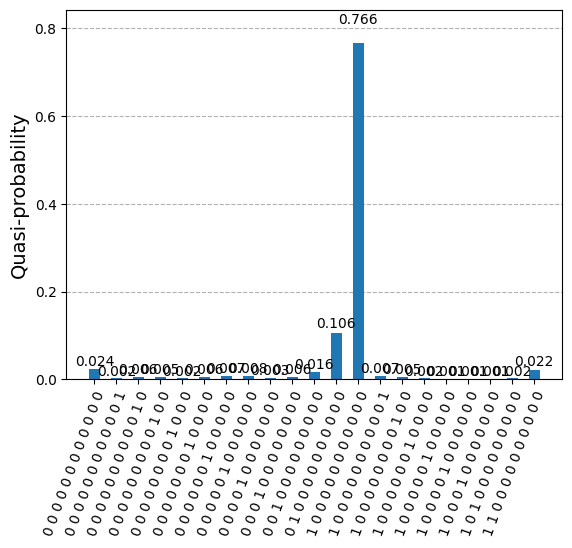

In [ ]:
samples_for_plot = {
    " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in samples
}

plot_histogram(samples_for_plot)

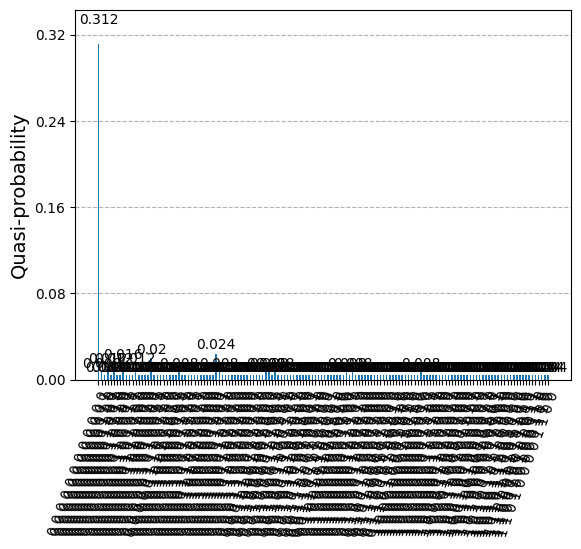

In [ ]:
noisy_samples_for_plot = {
    " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in noisy_samples
}

plot_histogram(noisy_samples_for_plot)

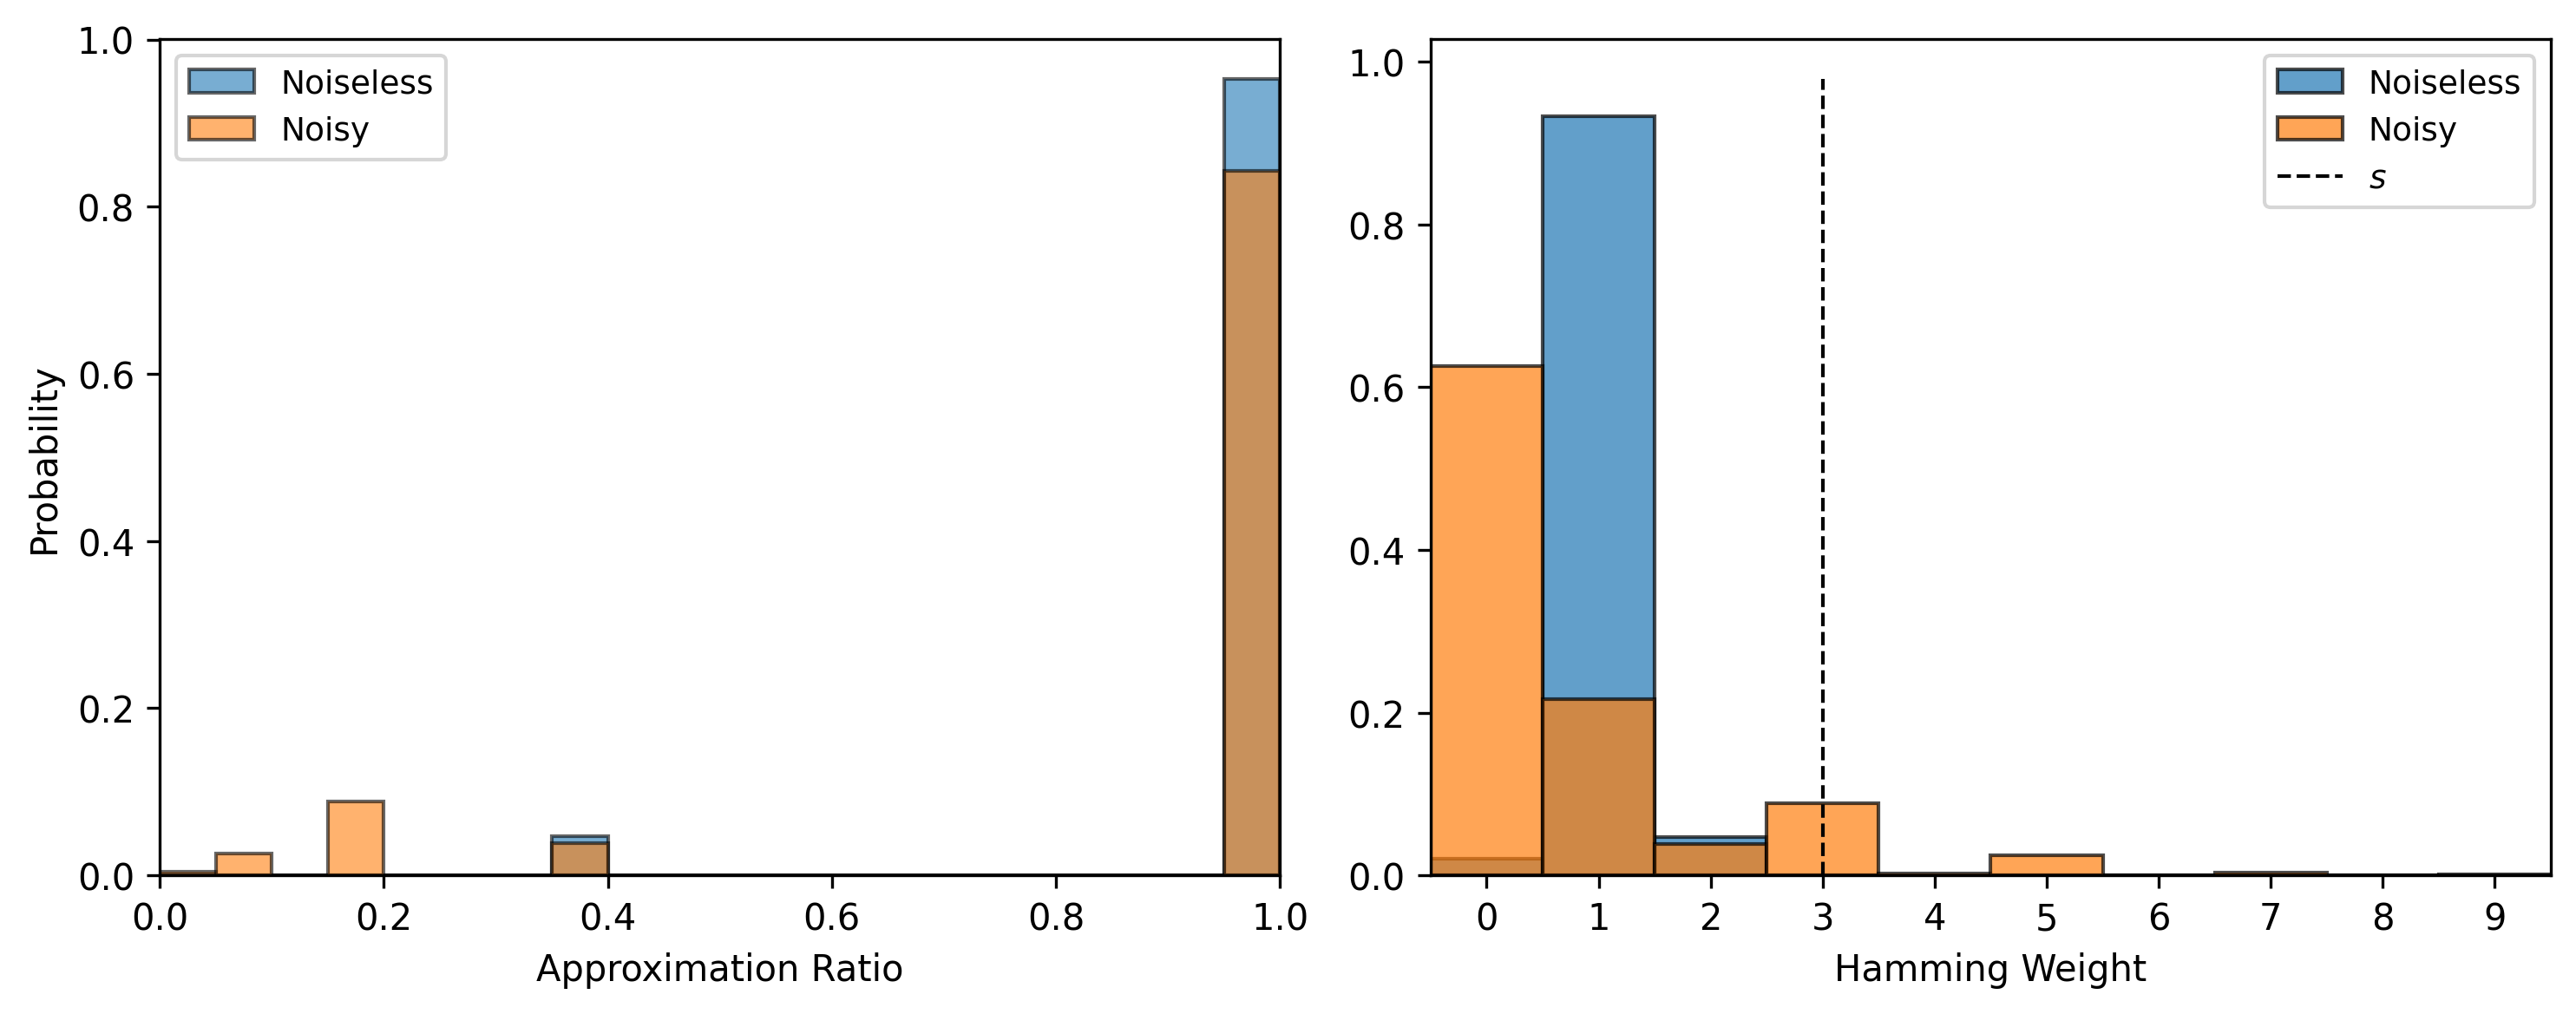

In [ ]:
# --- (Re)compute your empirical data arrays ---
probabilities       = [s.probability for s in samples]
approx_ratios       = [optimal_value / s.fval   for s in samples]
hamming_weights     = [sum(s.x)                for s in samples]

noisy_probabilities = [s.probability for s in noisy_samples]
noisy_approx_ratios = [optimal_value / s.fval   for s in noisy_samples]
noisy_hamming_weights = [sum(s.x)                for s in noisy_samples]

# --- Define common bins ---
# For approximation ratio: from 0 to 1 in 20 equal bins
ratio_bins   = np.linspace(0.0, 1.0, 21)

# For Hamming weight: integer bins from min to max, with half‑bin padding
max_h = max(max(hamming_weights), max(noisy_hamming_weights))
hamming_bins = np.arange(-0.5, max_h + 1.5, 1.0)

# --- Create figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# (a) Approximation Ratio
ax1.hist(approx_ratios,
         bins=ratio_bins,
         weights=probabilities,
         alpha=0.6,
         edgecolor='black',
         label='Noiseless')
ax1.hist(noisy_approx_ratios,
         bins=ratio_bins,
         weights=noisy_probabilities,
         alpha=0.6,
         edgecolor='black',
         label='Noisy')

ax1.set_xlabel("Approximation Ratio", fontsize=10)
ax1.set_ylabel("Probability",        fontsize=10)
ax1.set_xlim(0, 1.0)
ax1.set_xticks(np.linspace(0,1,6))
ax1.legend(loc='upper left', fontsize=9)
# ax1.text(0.02, 0.95, "(a)",
#          transform=ax1.transAxes,
#          fontsize=12, fontweight='bold',
#          va='top')

# (b) Hamming Weight
ax2.hist(hamming_weights,
         bins=hamming_bins,
         weights=probabilities,
         alpha=0.7,
         edgecolor='black',
         label='Noiseless')
ax2.hist(noisy_hamming_weights,
         bins=hamming_bins,
         weights=noisy_probabilities,
         alpha=0.7,
         edgecolor='black',
         label='Noisy')

# vertical line at s
ax2.vlines(s,
           ymin=0,
           ymax=ax2.get_ylim()[1],
           linestyles='dashed',
           linewidth=1,
           color='black',
           label=r'$s$')

ax2.set_xlabel("Hamming Weight", fontsize=10)
ax2.set_xlim(-0.5, max_h + 0.5)
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.legend(loc='upper right', fontsize=9)
# ax2.text(0.02, 0.95, "(b)",
#          transform=ax2.transAxes,
#          fontsize=12, fontweight='bold',
#          va='top')

# --- Final layout and save ---
plt.tight_layout()
plt.savefig("XY_hamming_and_approx_ratio.png", bbox_inches='tight')
plt.show()

In [ ]:
# We are minimizing fval
best_sample = samples[0]
best_sample_formatted = [int(x_i) for x_i in best_sample.x]
prob_best_sample = best_sample.probability
best_fval = best_sample.fval

samples.sort(key=lambda x: x.probability, reverse=True)
most_probable_sample = samples[0]
most_probable_sample_formatted = [int(x_i) for x_i in most_probable_sample.x]
prob_most_probable_sample = most_probable_sample.probability
most_probable_fval = most_probable_sample.fval

print("====Noiseless QAOA results====")
print(f"Best sample: {best_sample_formatted} with probability {prob_best_sample}")
print(f"Best value: {best_fval}")
print(f"Best approx ratio: {optimal_value / best_fval}")
print()
print(f"Most probable sample: {most_probable_sample_formatted} with probability {prob_most_probable_sample}")
print(f"Most probable value: {most_probable_fval}")
print(f"Most probable approx ratio: {optimal_value / most_probable_fval}")
print()
print()

#=====================================================
# Noisy QAOA
#=====================================================
print("====Noisy QAOA results====")
best_sample = noisy_samples[0]
best_sample_formatted = [int(x_i) for x_i in best_sample.x]
prob_best_sample = best_sample.probability
best_fval = best_sample.fval
noisy_samples.sort(key=lambda x: x.probability, reverse=True)
most_probable_sample = noisy_samples[0]
most_probable_sample_formatted = [int(x_i) for x_i in most_probable_sample.x]
prob_most_probable_sample = most_probable_sample.probability
most_probable_fval = most_probable_sample.fval
print(f"Best sample: {best_sample_formatted} with probability {prob_best_sample}")
print(f"Best value: {best_fval}")
print(f"Best approx ratio: {optimal_value / best_fval}")
print()
print(f"Most probable sample: {most_probable_sample_formatted} with probability {prob_most_probable_sample}")
print(f"Most probable value: {most_probable_fval}")
print(f"Most probable approx ratio: {optimal_value / most_probable_fval}")

====Noiseless QAOA results====
Best sample: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.005859375
Best value: 5.626523996144061
Best approx ratio: 1.0

Most probable sample: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.642578125
Most probable value: 5.626523996144061
Most probable approx ratio: 1.0


====Noisy QAOA results====
Best sample: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.0009765625
Best value: 5.626523996144061
Best approx ratio: 1.0

Most probable sample: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.087890625
Most probable value: 5.688283159803952
Most probable approx ratio: 0.9891427409773991
